In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 4.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=8677d5d8140f4488fb387134b4195872e05457db182e6ac130d27789962501cb
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


# Загрузка данных

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "" # username from the json file
os.environ['KAGGLE_KEY'] = "" # key from the json file
!kaggle competitions download -c realestatepriceprediction

  0% 0.00/584k [00:00<?, ?B/s]
100% 584k/584k [00:00<00:00, 127MB/s]


In [3]:
!unzip \*.zip

Archive:  realestatepriceprediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


Id - идентификационный номер квартиры

DistrictId - идентификационный номер района

Rooms - количество комнат

Square - площадь

LifeSquare - жилая площадь

KitchenSquare - площадь кухни

Floor - этаж

HouseFloor - количество этажей в доме

HouseYear - год постройки дома

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

Social_1, Social_2, Social_3 - социальные показатели местности

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

Price - цена квартиры

# EDA


In [4]:
!pip install catboost

     |████████████████████████████████| 65.7MB 45kB/s 


In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv, sum_models
from catboost import Pool, cv
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import random


In [6]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_submission = pd.read_csv('sample_submission.csv')

In [7]:
print(df_train.shape)
df_train.head(5)

(10000, 20)


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [8]:
print(df_test.shape)
df_test.head(5)

(5000, 19)


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [9]:
print(df_submission.shape)
df_submission.head(5)

(5000, 2)


,Id,Price
0,725,200000.0
1,15856,200000.0
2,5480,200000.0
3,15664,200000.0
4,14275,200000.0


для df_test нет данных по цене. То что в sample_submission это пример для загрузки на проверку в кагл. Поэтому будем пользоваться df_train. И его разбивать еще на трэи и тест

Посмотрим на количество пропусков и сделаем замену 

In [10]:
df_train.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Есть пропуски по признаку LifeSquare - примерно для 21% наблюдений. и по признаку Healthcare_1 почти для половины наблюдений.

Healthcare_1  я предалагаю выкиинуть вообще, так как слишком много свободы по нему. А пропуски в Lifesquare нужно заменить, так как важный признак. Гипотеза, что можно взять среднюю додя жилой площади от общей для наблюдений без пропусков. И домножить ее на общую площадь, где есть пропуски. Можно попробовать более сложные вычисления, чтобы учитывало значения доля в зависимости от размера квартиры. 

Удалим колонку Healthcare_1


In [11]:
df_train = df_train.drop('Healthcare_1', axis =1)

Найдем среднее значение Lifesquare rete и заполним при помощи его пропуски

In [12]:
Lifesquare_rate = np.mean(df_train[df_train['LifeSquare'].notnull()]['LifeSquare'] / df_train[df_train['LifeSquare'].notnull()]['Square'])
df_train['LifeSquare'] = df_train['LifeSquare'].fillna(df_train['Square'] * Lifesquare_rate)
df_train.isnull().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

Ура! Избавились от пропусков

Посмотрим на типы признаков в нашем датасете

In [13]:
df_train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Ecology_2, Ecology_3, Shops_2 - категориальные признаки. Возможно порядковые. По описанию непонятно. Но похоже на рейтинги

In [14]:
df_train[['Ecology_2', 'Ecology_3', 'Shops_2']].nunique()

Ecology_2    2
Ecology_3    2
Shops_2      2
dtype: int64

Посколько везде по 2 уникальных значения, то можем просто закодировать бинарно. 

Стоит проверить уникальные значения остальных переменных 

In [15]:
df_train.nunique()

Id               10000
DistrictId         205
Rooms                9
Square           10000
LifeSquare       10000
KitchenSquare       58
Floor               33
HouseFloor          44
HouseYear           97
Ecology_1          129
Ecology_2            2
Ecology_3            2
Social_1            51
Social_2           142
Social_3            30
Helthcare_2          7
Shops_1             16
Shops_2              2
Price            10000
dtype: int64

Привлкают внимания такие переменные, как DistrictId, Social_1, Social_3, Helthcare_2, Shops_1. Потому что у них не так много уникальных значений. И по смыслу не очень понятно что-это. Но они все уже переведены в числа. Будем надеяться, что они учитывают расстояние между порядками. Можем проверить через матрицу корреляций. Гипотеза, что если корреляция есть, то кодирование этих признаков учитвает расстояние между категориями.

Так же исключительно по смыслу категориальными являются HouseFloor и HouseYear

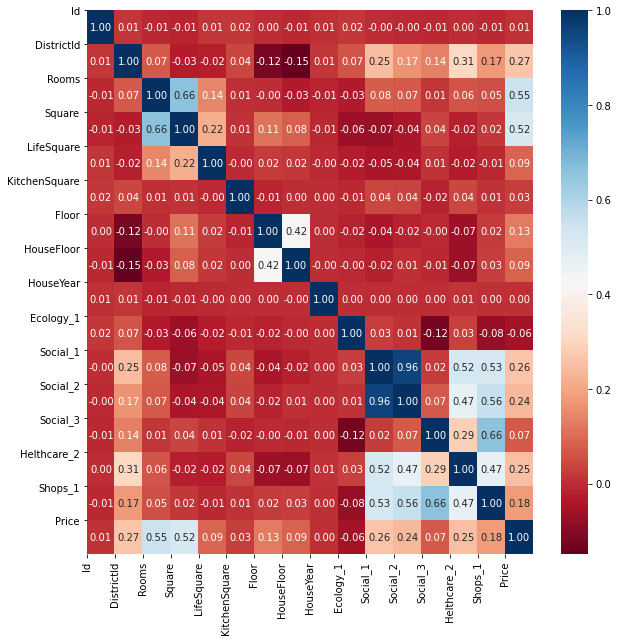

In [16]:
corr = df_train.corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

Корреляция для данных признаком на самом деле выше, чем для других поэтому ничего пока не будем с ними делать.

Заменим то, что хотели заменить

In [17]:
df_train_enc = pd.get_dummies(df_train)
df_train_enc.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,0,11,184966.930730,0,1,0,1,0,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,1,16,300009.450063,0,1,0,1,0,1
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,1,3,220925.908524,0,1,0,1,0,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,5735,3,0,5,175616.227217,0,1,0,1,0,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2,4,150226.531644,0,1,0,1,0,1


# Обучение  CatBoost

Возьмем пока не перекодированный датасет, потому что катбуст сам может все откодировать 

In [18]:
df_train['HouseFloor'] = df_train['HouseFloor'].apply(lambda x: int(x))
X = df_train.drop(['Id','Price'], axis = 1)
y = df_train['Price']

In [19]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=23, shuffle = True)

X_train, X_eval, y_train, y_eval = train_test_split(train_X, train_y, test_size=0.33, random_state=23, shuffle = True)

In [20]:
X.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
0,35,2.0,47.981561,29.442751,6.0,7,9,1969,0.089040,B,B,33,7976,5,0,11,B
1,41,3.0,65.683640,40.049543,8.0,7,9,1978,0.000070,B,B,46,10309,1,1,16,B
2,53,2.0,44.947953,29.197612,0.0,8,12,1968,0.049637,B,B,34,7759,0,1,3,B
3,58,2.0,53.352981,52.731512,9.0,8,17,1977,0.437885,B,B,23,5735,3,0,5,B
4,99,1.0,39.649192,23.776169,7.0,11,12,1976,0.012339,B,B,35,5776,1,2,4,B


In [21]:
cat_features = [0,6,7,9,10, 13,14,15,16]
train_data = X_train
train_labels = y_train


train_dataset = Pool(data=X_train,
                     label=y_train,
                     cat_features=cat_features)

eval_dataset = Pool(data=X_eval,
                    label=y_eval,
                    cat_features=cat_features)

In [22]:
model = CatBoostRegressor(iterations=20000,
                           grow_policy="Depthwise",
                           loss_function = 'RMSE',
                           eval_metric = 'R2',
                           early_stopping_rounds = 1000,
                           task_type="GPU", 
                           devices='0', 
                           verbose = True,
                           use_best_model=True
                         )

In [23]:
model.fit(train_dataset, eval_set=eval_dataset, logging_level='Silent', plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


In [29]:
Y_hat_train = model.predict(X_train)
Y_hat = model.predict(X_eval)

In [31]:
print(r2_score(y_train, Y_hat_train))
print(r2_score(y_eval, Y_hat))

0.905979181754081
0.7673616883064057
